In [4]:
import os
import torch
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
from easydict import EasyDict as edict

from main_monodepth_pytorch import Model
%reload_ext autoreload
%autoreload 2

## Train

Check if CUDA is available

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

2

In [4]:
torch.cuda.empty_cache()

In [ ]:
dict_parameters = edict({'data_dir':'data/kitti/train/',
                         'val_data_dir':'data/kitti/val/',
                         'model_path':'data/models/monodepth_resnet18_001.pth',
                         'output_directory':'data/output/',
                         'input_height':256,
                         'input_width':512,
                         'model':'resnet18_md',
                         'pretrained':True,
                         'mode':'train',
                         'epochs':200,
                         'learning_rate':1e-4,
                         'batch_size': 8,
                         'adjust_lr':True,
                         'device':'cuda:0',
                         'do_augmentation':True,
                         'augment_parameters':[0.8, 1.2, 0.5, 2.0, 0.8, 1.2],
                         'print_images':False,
                         'print_weights':False,
                         'input_channels': 3,
                         'num_workers': 8,
                         'use_multiple_gpu': False})

In [ ]:
model = Model(dict_parameters)
#model.load('data/models/monodepth_resnet18_001_last.pth')

In [ ]:
model.train()

## Test the model

In [1]:
import pickle

In [2]:
with open('filename.pickle', 'rb') as handle:
    maskbbox = pickle.load(handle)

In [5]:
labels_names=os.listdir('data/training/label_2/')

In [6]:
labels_names.sort()

In [7]:
gt = []
for i, label in enumerate(labels_names):
    temp=[]
    with open('data/training/label_2/'+label) as inputfile:
        for line in inputfile:
            temp.append(line.strip().split(' '))
    for line in temp:
        if line[0]=='Pedestrian':
            gt.append([i, float(line[4]), float(line[5]), float(line[6]), float(line[7]), float(line[-2])])
print(len(gt))

4487


In [8]:
maskbbox=np.delete(maskbbox, (0), axis=0)

In [10]:
def get_inter_area(r1, r2):
    left = max(r1[0], r2[0])
    right = min(r1[2], r2[2])
    bottom = max(r1[1], r2[1])
    top = min(r1[3], r2[3])
    return (top-bottom)*(right-left)


In [11]:
all_images = list(set(gt[:,0].astype(int)))
final_boxes = []
for i in all_images:
    if len(gt[gt[:,0]==i])==0 or len(maskbbox[maskbbox[:,0]==i])==0:
        continue
    inter_matrix = np.zeros((len(gt[gt[:,0]==i]),len(maskbbox[maskbbox[:,0]==i])))
    for l, tbbox in enumerate(gt[gt[:,0]==i]):
        for k, mbbox in enumerate(maskbbox[maskbbox[:,0]==i]):
            inter_matrix[l,k]=get_inter_area(tbbox[1:5], mbbox[1:])
    
    for l in range(len(inter_matrix)):
        final_boxes.append(np.append(maskbbox[maskbbox[:,0]==i][np.argmax(inter_matrix[l])],gt[gt[:,0]==i][l,-1]))     

In [141]:
dict_parameters_test = edict({'data_dir':'data/test',
                              'model_path':'data/models/monodepth_resnet18_001.pth',
                              'output_directory':'data/output/',
                              'input_height':256,
                              'input_width':512,
                              'model':'resnet18_md',
                              'pretrained':True,
                              'mode':'test',
                              'device':'cuda:0',
                              'input_channels':3,
                              'num_workers':4,
                              'use_multiple_gpu':False})
model_test = Model(dict_parameters_test)

Use a dataset with 7481 images


In [142]:
model_test.test()

Finished Testing


In [12]:
disp = np.load('data/output/disparities_pp.npy')  # Or disparities.npy for output without post-processing
disp.shape

(7481, 256, 512)

In [13]:
np.array(final_boxes).shape

(4156, 6)

In [91]:
errors = []
for box in final_boxes:
    disp_to_img = skimage.transform.resize(disp[int(box[0])].squeeze(), [375, 1242], mode='constant')
    depth = 0.54 * 721 / (1242 * disp_to_img) - 5.04
    pred=depth[int((final_boxes[2][1+1]+final_boxes[2][3+1])/2):int((final_boxes[2][1+1]+final_boxes[2][3+1])/2)+10,
                int((final_boxes[2][0+1]+final_boxes[2][2+1])/2):int((final_boxes[2][0+1]+final_boxes[2][2+1])/2)+10].mean()
    gtruth=box[-1]
    errors.append([gtruth,pred,pred-gtruth])

    

In [93]:
errors=np.array(errors)

In [94]:
clean_errors = errors[errors[:,2]<80]

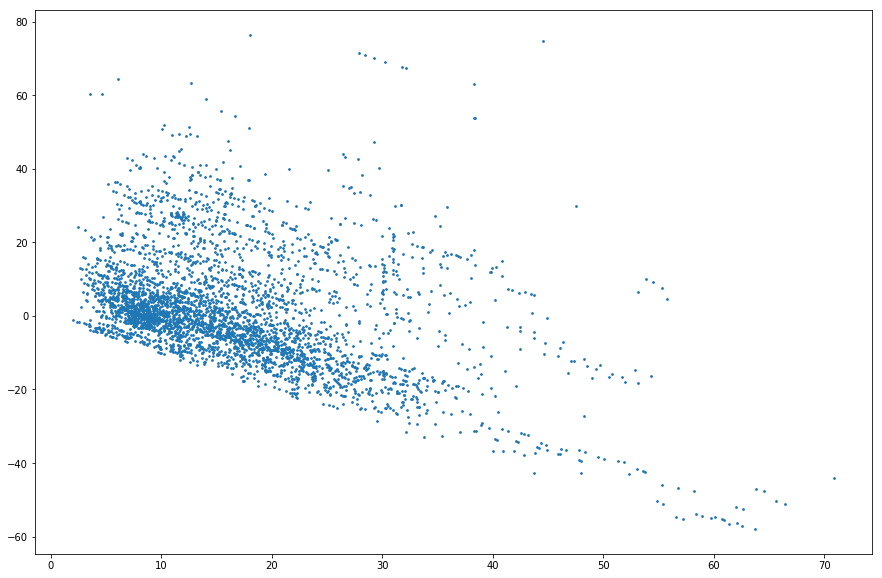

In [95]:
plt.scatter(clean_errors[:,0],clean_errors[:,2],s=3)
plt.show()

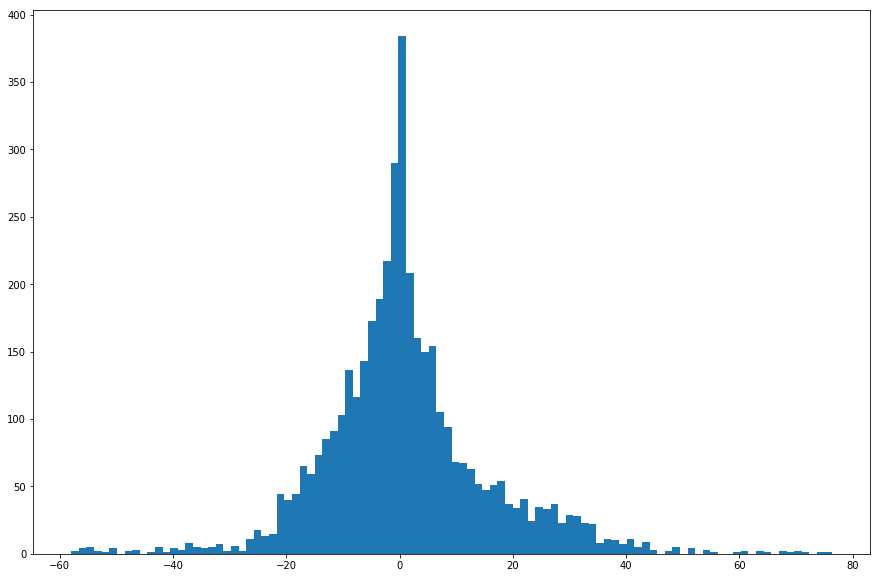

In [96]:
plt.hist(clean_errors[:,2], bins=100)
plt.show()

In [101]:
print(abs(errors[:,2]).mean())
print(np.median(abs(errors[:,2])))

print(len(errors[abs(errors[:,2])<0.5])/len(errors)*100)
print(len(errors[abs(errors[:,2])<1])/len(errors)*100)
print(len(errors[abs(errors[:,2])<2])/len(errors)*100)

11.9981134368
6.79898479412
7.386910490856594
13.354186717998076
21.583253128007698


In [103]:
fig,ax = plt.subplots(1)

In [104]:
disp_to_img = skimage.transform.resize(disp[0].squeeze(), [375, 1242], mode='constant')
ax.imshow(disp_to_img, cmap='plasma')

In [106]:
ax.add_patch(
            plt.Rectangle((final_boxes[0][0+1], final_boxes[0][1+1]),
                          final_boxes[0][2+1] - final_boxes[0][0+1],
                          final_boxes[0][3+1] - final_boxes[0][1+1],
                          fill=False, edgecolor='white',
                          linewidth=0.5, alpha=1))

In [107]:
depth = 0.54 * 721 / (1242 * disp_to_img)

In [108]:
depth[int(final_boxes[0][1+1]):int(final_boxes[0][3+1]),int(final_boxes[0][0+1]):int(final_boxes[0][2+1])].min()

8.7478429798315549

In [109]:
final_boxes[0][-1]

8.4100000000000001

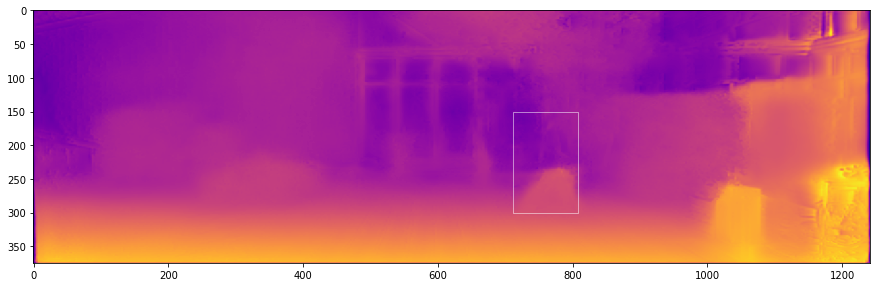

In [110]:
plt.show()

In [ ]:
fig = plt.figure(frameon=False)
    fig.set_size_inches(im.shape[1] / dpi, im.shape[0] / dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.axis('off')
    fig.add_axes(ax)
    ax.imshow(im)

Save a color image

In [11]:
plt.imsave(os.path.join(dict_parameters_test.output_directory,
                        dict_parameters_test.model_path.split('/')[-1][:-4]+'_test_output.png'), disp_to_img, cmap='plasma')

Save all test images

In [15]:
for i in range(disp.shape[0]):
    disp_to_img = skimage.transform.resize(disp[i].squeeze(), [375, 1242], mode='constant')
    plt.imsave(os.path.join(dict_parameters_test.output_directory,
               'pred_'+str(i)+'.png'), disp_to_img, cmap='plasma')

Save a grayscale image

In [ ]:
plt.imsave(os.path.join(dict_parameters_test.output_directory,
                        dict_parameters_test.model_path.split('/')[-1][:-4]+'_gray.png'), disp_to_img, cmap='gray')